# MayaVi for Data Analysis

Our goal here is to use MayaVi to effectively analyze 3D datasets.  We shall show how to save the data to an HDF5 file, then load it for visualization in MayaVi.  We assume that the data sets are large, and so try to use data sources that only load the required data into memory.  Our data will be simple: rectagular meshes.

<!-- TEASER_END -->

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#MayaVi-for-Data-Analysis" data-toc-modified-id="MayaVi-for-Data-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>MayaVi for Data Analysis</a></div><div class="lev1 toc-item"><a href="#Jupyter-Notebook" data-toc-modified-id="Jupyter-Notebook-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Jupyter Notebook</a></div><div class="lev1 toc-item"><a href="#Example" data-toc-modified-id="Example-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Example</a></div><div class="lev2 toc-item"><a href="#Generating-Data" data-toc-modified-id="Generating-Data-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generating Data</a></div><div class="lev2 toc-item"><a href="#MayaVi" data-toc-modified-id="MayaVi-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>MayaVi</a></div>

# Jupyter Notebook

MayaVi can be run in a notebook.  Instructions are [provided in the documentation](http://docs.enthought.com/mayavi/mayavi/tips.html#using-mayavi-in-jupyter-notebooks):  Here is what I needed to do on the server (after updating various packages like `notebook`.)

```bash
conda install mayavi
jupyter nbextension install --py mayavi
```

This might work locally, but trying to use the notebooks across the network gives rise to the following error:

```bash
__main__.py: cannot connect to X server
```

This is discussed in [Issue #439: Kernel dies on mlab import at jupyter notebook](https://github.com/enthought/mayavi/issues/439).



# Example

## Generating Data

Here we generate the generation of some simple data - in this case a mock simulation of a vortex moving through a cloud.

In [4]:
import h5py
import numpy as np

Nt = 100
Nx = Ny = 128
Nz = 512
lam = 8.0    # Aspect ratio
x = np.linspace(-1, 1, Nx)[:, None, None]
y = np.linspace(-1, 1, Ny)[None, :, None]
z = np.linspace(-lam, lam, Nz)[None, None, :]

xi = 0.1     # Size of vortex core
V = x**2 + y**2 + (z/lam)**2
mu = 0.8**2
phi0 = np.where(V<mu, abs(V - mu)**(3./4.), 0)

def psi_t(t, R=0.5, T=1.0):
    """Return psi for vortex at time t.
    
    Vortex orbits at effective radius R with period T
    """
    theta = 2*np.pi*t/T
    z0 = lam*R*np.cos(theta)
    y0 = R*np.sin(theta)
    _z = z-z0 + (y-y0)*1j
    _r = abs(_z)
    return phi0 * (z-z0 + (y-y0)*1j) / np.sqrt(2*xi**2 + _r**2)

_MB = Nx*Ny*Nz*np.dtype(complex).itemsize / 1024.**2
print("Each frame is %g MB" % (_MB,))
print("%i frames will be %g GB" % (Nt, Nt*_MB/1024.,))

Each frame is 128 MB
100 frames will be 12.5 GB


Here are some slices showing the vortex position.

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


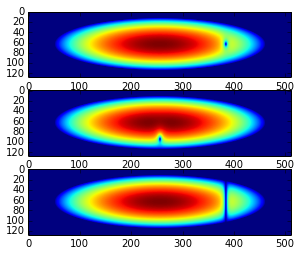

In [51]:
%pylab inline
subplot(311)
imshow(abs(psi_t(0))[Nx//2, :, :])
subplot(312)
imshow(abs(psi_t(0.25))[Nx//2, :, :])
subplot(313)
imshow(abs(psi_t(0))[:, Ny//2, :])

In order to be able to load the data directly into VisIt and similar programs, we use an (undocumented?) convention of a "Pixie" format.  This requires storing each array in a group called ``/Timestep_%i`` where ``%i`` is the frame number.  Within each group, one can store different variables.

Here is the *extremely* sparse documentation I have found:
* [Reverse engineering the VisIt test data](https://elist.ornl.gov/pipermail/visit-users/2013-February/013761.html)

In [54]:
filename = 'vortex.h5'
if os.path.exists(filename):
    os.remove(filename)

zero = np.zeros((Nx, Ny, Nz))
with h5py.File(filename) as f:
    pass
    #f['node_coords/X'] = x + zero#.ravel()
    #f['node_coords/Y'] = y + zero#.ravel()
    #f['node_coords/Z'] = z + zero#.ravel()

    #f['Origin'] = np.array([_x.min() for _x in (z,y,x)])
    #f['DxDyDz'] = np.array([np.diff(_x.ravel())[0] for _x in (z,y,x)])
    
ts = np.linspace(0, 1, Nt)
for _n, _t in enumerate(ts):
    if _n % 10 == 0:
        print("Frame %i of %i" % (_n, Nt))
    with h5py.File(filename) as f:
        grp = 'Timestep_%i' % (_n,)
        f[grp + '/rho'] = abs(psi_t(_t))**2
        #f[grp].attrs['coords']=('/node_coords/X', '/node_coords/Y', '/node_coords/Z')

Frame 0 of 100
Frame 10 of 100
Frame 20 of 100
Frame 30 of 100
Frame 40 of 100
Frame 50 of 100
Frame 60 of 100
Frame 70 of 100
Frame 80 of 100
Frame 90 of 100


Now let's save 200 frames to a file.  There are some tricks here:

1. We don't want to keep all the images in memory, so we must make an extensible dataset in the HDF5 file.  We do this by explicitly creating a dataset with ``maxshape = (None, Nx, Ny, Nz)``.  This will allow us to add multiple arrays as we generate them (automatically increasing along the first dimension).
2. Accessing an existing array in the HDF5 file is different than creating a new array.  Thus, it is easist to delete the file first, but if you want to append, you will need some logic to check that the arrays are compatible if they already exist.
3. I am using a simple file here.  If you want to use a file in a directory, you will need to make sure that the directory exists first - just passing a full name to ``File`` will not create the directory.
4. It is very important to specify the ``chunks`` size if you want good performance.  (The default here immediately created an 8GB array!)

In [7]:
filename = 'vortex.h5'
if os.path.exists(filename):
    os.remove(filename)

with h5py.File(filename) as f:
    f.create_dataset('psis', shape=(0, Nx, Ny, Nz),
                     maxshape=(None, Nx, Ny, Nz),
                     chunks=(1, Nx, Ny, Nz),
                     dtype=double)
    f['x'] = x
    f['y'] = y
    f['z'] = z

ts = np.linspace(0, 1, Nt)
for _n, _t in enumerate(ts):
    if _n % 10 == 0:
        print("Frame %i of %i" % (_n, Nt))
    with h5py.File(filename) as f:
        psis = f['psis']
        psis.resize(_n+1, axis=0)
        psis[_n] = abs(psi_t(_t))

Frame 0 of 100
Frame 10 of 100
Frame 20 of 100
Frame 30 of 100
Frame 40 of 100
Frame 50 of 100
Frame 60 of 100
Frame 70 of 100
Frame 80 of 100
Frame 90 of 100


Here are some timings to estimate file access speeds. Apparently the time to open the file is insignificant, so we can do this repeatedly if needed.

In [158]:
%%timeit
with h5py.File('vortex.hd5') as f:
     psi = np.array(f['psis'][0])

10 loops, best of 3: 157 ms per loop


In [156]:
%%timeit
with h5py.File('vortex.hd5') as f:
    psi = np.array(f['psis'][Nt//2])

10 loops, best of 3: 158 ms per loop


In [160]:
%%timeit
with h5py.File('vortex.hd5') as f:
    psi = np.array(f['psis'][Nt - 1])

10 loops, best of 3: 156 ms per loop


In [159]:
with h5py.File('vortex.hd5') as f:
    %timeit psi = np.array(f['psis'][0])
    %timeit psi = np.array(f['psis'][Nt//2])
    %timeit psi = np.array(f['psis'][Nt-1])

10 loops, best of 3: 156 ms per loop
10 loops, best of 3: 155 ms per loop
10 loops, best of 3: 163 ms per loop


In [164]:
%%timeit
res = 0
with h5py.File('vortex.hd5') as f:
    for n in xrange(10):
        res += np.sum(f['psis'][np.random.randint(Nt)])

1 loops, best of 3: 2.27 s per loop


In [165]:
%%timeit
res = 0
for n in xrange(10):
    with h5py.File('vortex.hd5') as f:
        res += np.sum(f['psis'][np.random.randint(Nt)])

1 loops, best of 3: 2.26 s per loop


## MayaVi

Note: On Mavericks (OS X 9), there are issues related to running MayaVi.  In particular, the version of python running must be a "Framework" build.  This seems to mean that the kernel is started with the version of python in ``python.app/Contents/MacOS/python`` *with the explicit path specified*.  I.e. Even if you have a symlink to this on your path, it is not sufficient to use that.  You must invoke this explicitly.  To find out where this is, look at the ``mayavi2`` script:

In [3]:
!head -n1 $(type -p mayavi2)

#!/data/apps/anaconda/1.3.1/python.app/Contents/MacOS/python


In order to ensure that this is done properly here, all of our examples will be run as scripts, not from this notebook.  We start by making a little application that will display the frames.

In [131]:
%%script /data/apps/anaconda/1.3.1/python.app/Contents/MacOS/python
import numpy as np
import h5py

import traits.api as api
import traitsui.api as uapi

from mayavi.core.api import PipelineBase, Source
from mayavi.core.ui.api import MayaviScene, SceneEditor, MlabSceneModel
from mayavi.core.ui.engine_view import EngineView
from mayavi.sources.api import ArraySource

from tvtk.api import tvtk

from mayavi import mlab

class Data(api.HasTraits):
    _filename = 'vortex.hd5'
    filename = api.Str(_filename)
    with h5py.File(_filename) as f:
        frame = api.Range(0, f['psis'].shape[0])
        x = np.ravel(f['x'])
        y = np.ravel(f['y'])
        z = np.ravel(f['z'])

    @property
    def psi(self):
        with h5py.File(self.filename) as f:
            return np.asarray(f['psis'][self.frame])
        
    def __init__(self, **traits):
        api.HasTraits.__init__(self, **traits)


class MyModel(api.HasTraits):
    #data = api.Instance(Data)
    #filename = api.DelegatesTo('data')
    #frame = api.DelegatesTo('data')
    #scene = api.Instance(MlabSceneModel, ())
    #plot = api.Instance(PipelineBase)

    @property 
    def data(self):
        return self

    filename = api.Str('vortex.hd5')
    frame = api.Range(0, 99)

    @property
    def psi(self):
        with h5py.File(self.filename) as f:
            return np.asarray(f['psis'][self.frame])

    data_src = api.Instance(Source)
    data_src2 = api.Instance(Source)

    scene = api.Instance(MlabSceneModel, ())
    scene2 = api.Instance(MlabSceneModel, ())
    plot = api.Instance(PipelineBase)
    plot2 = api.Instance(PipelineBase)
        
    def __init__(self, **traits):
        api.HasTraits.__init__(self, **traits)
        with h5py.File(self.filename) as f:
            frame = api.Range(0, f['psis'].shape[0])
            x = np.asarray(f['x'])
            y = np.asarray(f['y'])
            z = np.asarray(f['z'])
        self.Nx, self.Ny, self.Nz = self.N = (len(x.ravel()), len(y.ravel()), len(z.ravel()))
        zero = np.zeros(self.N)

        self.data_src = mlab.pipeline.scalar_field(
            x + zero, y + zero, z + zero,
            abs(self.data.psi)**2,
            figure=self.scene.mayavi_scene,
            name='Density',)
        self.data_src2 = ArraySource(
            scene=self.scene2,
            parent=self.scene2,
            **self.data_src.get([
                'origin',
                'spacing',
                'image_data',
                'scalar_data',
                'name',
                'type',
                'scalar_name'
                'transpose_input_array',
                #'vector_name',
                #'outputs',
                #'input_info',
                #'change_information_filter',
                #'output_info',
                #'mlab_source',
                ]))
            
        #self.make_main_view()

        #self.outline = mlab.pipeline.outline(
        #    self.data_src.mlab_source.dataset,
        #    figure=self.scene2.mayavi_scene)
        
        #self.make_end_view()
        #_image_data = self.data_src.mlab_source.dataset
        #_image_data.spacing = tuple(np.diff(_x)[0] for _x in [x, y, z])
        #_image_data.origin = tuple(_x[0] for _x in [x, y, z])
        #_image_data.bounds = (x.min(), x.max(), y.min(), y.max(), z.min(), z.max())

    @api.on_trait_change('scene.activated')
    def make_main_view(self):
        mlab.pipeline.outline(self.data_src)
        mlab.pipeline.image_plane_widget(
            self.data_src, plane_orientation='x_axes', slice_index=self.Nx//2)
        mlab.pipeline.image_plane_widget(
            self.data_src, plane_orientation='y_axes', slice_index=self.Ny//2)
        
    @api.on_trait_change('scene2.activated')
    def make_end_view(self):
        mlab.pipeline.outline(self.data_src2,
                              figure=self.scene2.mayavi_scene)
        mlab.pipeline.image_plane_widget(#self.data_src.mlab_source.dataset,
            self.data_src2, 
            plane_orientation='x_axes', slice_index=self.Nx//2,
            figure=self.scene2.mayavi_scene)

        
        #mlab.pipeline.image_plane_widget(
        #    self.data_src.mlab_source.dataset, plane_orientation='y_axes', slice_index=self.Ny//2)
    
        #mlab.pipeline.image_plane_widget(
        #    self.data_src, plane_orientation='x_axes', slice_index=10)
        #mlab.pipeline.image_plane_widget(
        #    self.data_src, plane_orientation='y_axes', slice_index=10)


    # When the scene is activated, or when the parameters are changed, we
    # update the plot.
    @api.on_trait_change('frame')
    def update_plot(self):
        self.data_src.mlab_source.set(scalars=abs(self.data.psi)**2)
        self.data_src2.update()

    # The layout of the dialog created
    view = uapi.View(
        uapi.Item('scene', editor=SceneEditor(scene_class=MayaviScene),
                  height=250, width=300, show_label=False),
        uapi.Item('scene2', editor=SceneEditor(scene_class=MayaviScene),
                  height=250, width=300, show_label=False),
        uapi.Group(
            '_', 'frame',
        ),
        resizable=True,
    )

my_model = MyModel()
my_model.configure_traits()

/BUILD/wxPython-src-3.0.0.0/src/common/module.cpp(194): assert "module->m_state == State_Initialized" failed in DoCleanUpModules(): not initialized module being cleaned up


In [71]:
%%script /data/apps/anaconda/1.3.1/python.app/Contents/MacOS/python
import numpy as np
import h5py
from tvtk.api import tvtk
from mayavi import mlab

grid = tvtk.RectilinearGrid()
with h5py.File('vortex.hd5') as f:
    grid.x_coordinates = np.ravel(f['x'])
    grid.y_coordinates = np.ravel(f['y'])
    grid.z_coordinates = np.ravel(f['z'])

def set_frame(frame, grid=grid):
    with h5py.File('vortex.hd5') as f:
        psi = np.asarray(f['psis'][frame])
        grid.point_data.scalars = abs(psi).ravel()
        grid.point_data.scalars.name = 'density'
        grid.dimensions = psi.shape

set_frame(0)
mlab.pipeline.iso_surface(grid)

Process is terminated.


In [ ]:
from tvtk.api import tvtk
tvtk.ImageData?

In [ ]:
import mayavi
import mayavi.mlab as mlab